### Import Libraries

In [1]:
import matplotlib.pyplot as plt
from typing import List, Tuple
from pprint import pprint
plt.rcParams["figure.figsize"] = (15,15)

### Define Constants

The numbers with regard to debt/salary/etc are MADE UP for demonstration purposes. 

In [2]:
TARGET_INFLATION = 1.02 # Target of 2%
WORST_CASE_INTEREST = 1.05 # 5% = 2% PRI + 3
MAX_YEARS = 30 # loan gets wiped
THRESHOLD_PAYMENT = 26_575 # TODO: might be subject to inflation

TOTAL_DEBT = 80_000 # ENTER YOUR TOTAL DEBT
BASE_SALARY = 26_000 # ENTER YOUR BASE SALARY
MAX_SALARY = 80_000 # ENTER YOUR EXPECTED MAX SALARY
SALARY_INCREASE = 1.03 # ENTER YOUR SALARY INCREASE PER YEAR EXPECTATIONS e.g. 1.03 for 3%
SALARY_EXPECTATIONS = [min(BASE_SALARY * (SALARY_INCREASE ** year), MAX_SALARY) for year in range(MAX_YEARS)]
MINIMUM_PAYMENTS = [(salary - THRESHOLD_PAYMENT) * 0.09 for salary in SALARY_EXPECTATIONS] # 9% of salary past beyond the threshold

### Calculate

In [3]:
def calculate_debt(payments: List) -> Tuple[List, float]:
    """ accepts a list of yearly payments, returns a list of yearly remaining debt and the total paid"""
    assert len(payments) == MAX_YEARS

    debt_remaining = TOTAL_DEBT
    yearly_remaining = []
    total_paid = 0
    for i in range(MAX_YEARS):
        yearly_remaining.append(debt_remaining)
        
        if debt_remaining == 0:
            continue
        
        # pay down debt
        total_paid += payments[i]
        debt_remaining = max(debt_remaining - payments[i], 0)
    
        # add interest
        debt_remaining = debt_remaining * WORST_CASE_INTEREST

    return yearly_remaining, total_paid

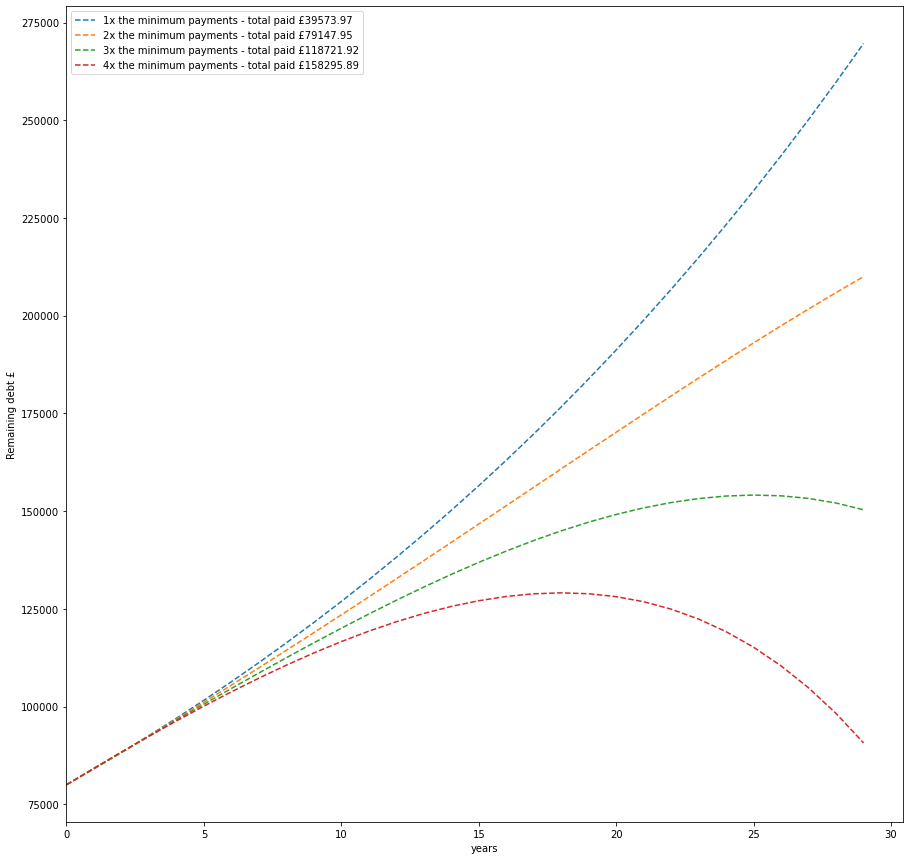

In [4]:
for n_times_minimum in range(1, 5):
    debt_over_time, total_paid = calculate_debt(list(map(lambda x: x * n_times_minimum, MINIMUM_PAYMENTS)))
    plt.plot(debt_over_time, 
             label=str(f"{n_times_minimum}x the minimum payments - total paid £{round(total_paid, 2)}"), 
             linestyle="dashed")
    
plt.legend()
plt.xlabel("years")
plt.xlim(0, None)
plt.ylabel("Remaining debt £")
plt.show()